In [18]:

# 1. Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings and visualization style
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')

# Enable inline plotting for Jupyter
%matplotlib inline


In [ ]:

# 2. Load all datasets from Excel file
customers = pd.read_excel("C:/Users/ASUS/Desktop/Insurance/data-analyst-task-datasets.xlsx", sheet_name="customers")
policies = pd.read_excel("C:/Users/ASUS/Desktop/Insurance/data-analyst-task-datasets.xlsx", sheet_name="policies")
claims = pd.read_excel("C:/Users/ASUS/Desktop/Insurance/data-analyst-task-datasets.xlsx", sheet_name="claims")
payments = pd.read_excel("C:/Users/ASUS/Desktop/Insurance/data-analyst-task-datasets.xlsx", sheet_name="payments")

# Preview dataframes
for name, df in {'customers': customers, 'policies': policies, 'claims': claims, 'payments': payments}.items():
    print(f"\n{name.upper()} DATASET:")
    display(df.head())
    print(df.shape)



CUSTOMERS DATASET:


,customer_id,full_name,gender,birth_date,region,join_date
0,1,Narmin Huseynova,M,2007-07-03,Absheron,2024-01-11
1,2,Zeynab Babayeva,F,2002-11-08,Baku,2023-03-17
2,3,Lamiya Gasimova,F,1991-04-08,Shaki,2025-03-16
3,4,Narmin Mammadova,M,2012-07-29,Shirvan,2025-06-11
4,5,Rashad Iskandarov,M,1963-05-02,Masazir,2023-06-18


(1000, 6)

POLICIES DATASET:


,policy_id,customer_id,insurance_type,start_date,end_date,premium_amount,channel,status,broker_name
0,10001,318,Property,2023-09-03,2024-07-22,30.00,agent,Active,NaN
1,10002,843,Property,2022-01-26,2023-04-18,646.94,agent,Active,NaN
2,10003,36,Property,2024-07-10,2025-02-07,323.17,online,Active,NaN
3,10004,447,Motor,2023-09-15,2025-01-31,420.89,broker,Expired,TrustLine
4,10005,801,Medical,2024-11-22,2025-11-22,1289.47,broker,Active,Atlas Brokers


(5000, 9)

CLAIMS DATASET:


,claim_id,policy_id,claim_date,claim_amount,approved_amount,claim_status,claim_reason
0,900000,10137,2024-08-30,656.23,0.00,Rejected,Hospitalization
1,900001,11094,2022-12-25,445.41,305.45,Approved,Surgery
2,900002,14122,2024-08-13,600.54,0.00,Submitted,Illness
3,900003,10018,2025-04-03,108.83,0.00,Rejected,Theft
4,900004,14602,2024-09-25,114.87,0.00,Rejected,Glass


(8000, 7)

PAYMENTS DATASET:


,payment_id,policy_id,payment_date,payment_amount,payment_method,is_overdue
0,500000,11098,2022-09-16,1016.42,Cash,1
1,500006,12014,2022-09-28,155.51,Cash,1
2,500007,12014,2022-10-30,176.40,Card,1
3,500008,12014,2022-09-23,155.13,Transfer,1
4,500011,10643,2023-10-31,408.89,Card,1


(6000, 6)


In [20]:

# 3. Perform basic data quality checks
for name, df in {'customers': customers, 'policies': policies, 'claims': claims, 'payments': payments}.items():
    print(f"\n{name.upper()}")
    print("Missing values:\n", df.isna().sum())
    print("Duplicates:", df.duplicated().sum())
    print("Data types:\n", df.dtypes)



CUSTOMERS
Missing values:
 customer_id    0
full_name      0
gender         0
birth_date     0
region         0
join_date      0
dtype: int64
Duplicates: 0
Data types:
 customer_id             int64
full_name              object
gender                 object
birth_date     datetime64[ns]
region                 object
join_date      datetime64[ns]
dtype: object

POLICIES
Missing values:
 policy_id            0
customer_id          0
insurance_type       0
start_date           0
end_date             0
premium_amount       0
channel              0
status               0
broker_name       3264
dtype: int64
Duplicates: 0
Data types:
 policy_id                  int64
customer_id                int64
insurance_type            object
start_date        datetime64[ns]
end_date          datetime64[ns]
premium_amount           float64
channel                   object
status                    object
broker_name               object
dtype: object

CLAIMS
Missing values:
 claim_id           0
polic

In [21]:

# 4. Merge datasets properly (one-to-many handled via aggregation)

# Aggregate payments per policy
payment_summary = payments.groupby('policy_id', as_index=False).agg({
    'payment_amount': 'sum',
    'is_overdue': 'max'  # if any overdue exists, mark as 1
})

# Aggregate claims per policy
claim_summary = claims.groupby('policy_id', as_index=False).agg({
    'claim_id': 'count',
    'claim_amount': 'sum',
    'approved_amount': 'sum'
}).rename(columns={'claim_id': 'claim_count'})

# Merge in correct order:
# customers → policies → (claims + payments)
merged = (policies
          .merge(customers, on='customer_id', how='left')
          .merge(payment_summary, on='policy_id', how='left')
          .merge(claim_summary, on='policy_id', how='left'))

print("Merged shape:", merged.shape)
display(merged.head())


Merged shape: (5000, 19)


,policy_id,customer_id,insurance_type,start_date,end_date,premium_amount,channel,status,broker_name,full_name,gender,birth_date,region,join_date,payment_amount,is_overdue,claim_count,claim_amount,approved_amount
0,10001,318,Property,2023-09-03,2024-07-22,30.00,agent,Active,NaN,Orkhan Aliyev,F,1993-05-06,Shirvan,2021-02-03,27.90,1.0,2.0,2658.83,1739.13
1,10002,843,Property,2022-01-26,2023-04-18,646.94,agent,Active,NaN,Elvin Aliyeva,F,2008-01-14,Khachmaz,2022-05-03,674.60,0.0,1.0,747.84,622.85
2,10003,36,Property,2024-07-10,2025-02-07,323.17,online,Active,NaN,Vugar Babayeva,M,2003-03-30,Masazir,2025-05-29,330.75,1.0,1.0,550.59,315.07
3,10004,447,Motor,2023-09-15,2025-01-31,420.89,broker,Expired,TrustLine,Elvin Jafarova,M,2015-12-06,Khachmaz,2020-06-25,425.66,1.0,NaN,NaN,NaN
4,10005,801,Medical,2024-11-22,2025-11-22,1289.47,broker,Active,Atlas Brokers,Rashad Huseynov,M,1958-09-15,Masazir,2025-02-25,NaN,NaN,3.0,1321.14,690.18


In [22]:

# 5. Calculate portfolio KPIs
total_premium = merged['premium_amount'].sum()
total_claims = merged['approved_amount'].sum()
claim_ratio = total_claims / total_premium
renewed = merged[merged['status'] == 'Renewed'].shape[0]
expired = merged[merged['status'] == 'Expired'].shape[0]
renewal_rate = renewed / expired if expired != 0 else np.nan

print(f"Total Premium: {total_premium:,.0f}")
print(f"Total Approved Claims: {total_claims:,.0f}")
print(f"Claim Ratio: {claim_ratio:.2%}")
print(f"Renewal Rate: {renewal_rate:.2%}")


Total Premium: 3,150,381
Total Approved Claims: 1,529,690
Claim Ratio: 48.56%
Renewal Rate: 82.47%


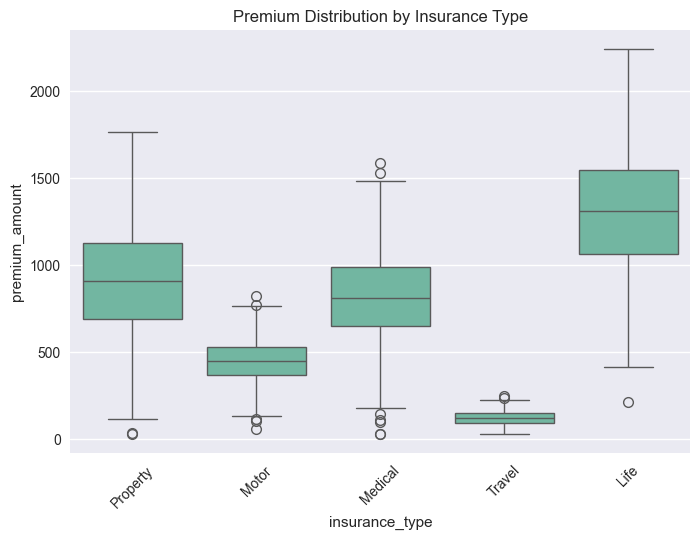

Outlier count: 79


In [23]:

# 6. Analyze premium distribution and detect outliers using IQR
sns.boxplot(data=merged, x='insurance_type', y='premium_amount')
plt.title("Premium Distribution by Insurance Type")
plt.xticks(rotation=45)
plt.show()

# Outlier detection
Q1 = merged['premium_amount'].quantile(0.25)
Q3 = merged['premium_amount'].quantile(0.75)
IQR = Q3 - Q1
outliers = merged[(merged['premium_amount'] < Q1 - 1.5*IQR) | (merged['premium_amount'] > Q3 + 1.5*IQR)]
print(f"Outlier count: {len(outliers)}")


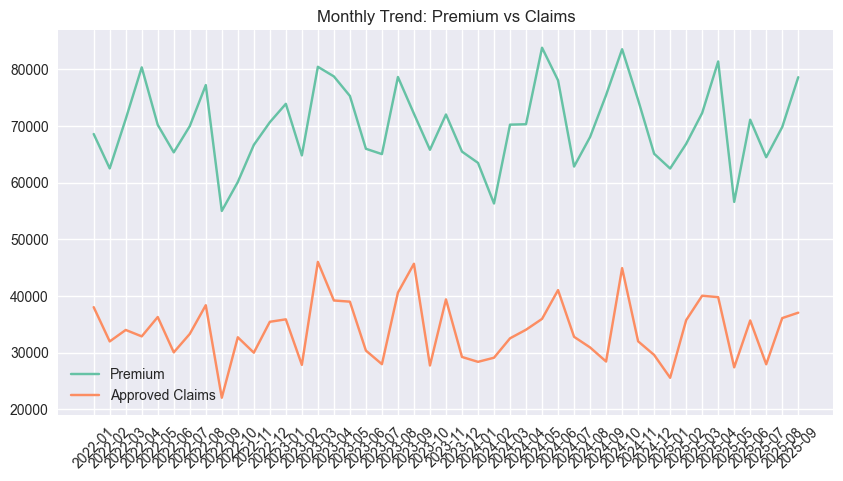

In [24]:

# 7. Plot monthly premium and approved claim trends
merged['start_month'] = pd.to_datetime(merged['start_date']).dt.to_period('M').astype(str)
monthly = merged.groupby('start_month').agg({
    'premium_amount':'sum',
    'approved_amount':'sum'
}).reset_index()

plt.figure(figsize=(10,5))
plt.plot(monthly['start_month'], monthly['premium_amount'], label='Premium')
plt.plot(monthly['start_month'], monthly['approved_amount'], label='Approved Claims')
plt.title("Monthly Trend: Premium vs Claims")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [25]:
# 8. Identify high-risk customers (loss ratio > 0.8 or >3 claims)
risk = merged.groupby('customer_id').agg({
    'approved_amount':'sum',
    'premium_amount':'sum',
    'claim_count':'sum'
}).reset_index()

risk['loss_ratio'] = risk['approved_amount'] / risk['premium_amount']
high_risk = risk[(risk['loss_ratio'] > 0.8) | (risk['claim_count'] > 3)]
print(f"High-risk customers: {high_risk.shape[0]}")
display(high_risk.head())


High-risk customers: 848


,customer_id,approved_amount,premium_amount,claim_count,loss_ratio
0,1,2383.61,3427.09,16.0,0.695520
2,3,123.33,1339.83,5.0,0.092049
3,4,1410.25,4203.14,12.0,0.335523
4,5,1002.74,6800.37,12.0,0.147454
5,6,219.15,2274.24,6.0,0.096362


,region,claim_count,policy_id,avg_claim_severity,claim_frequency
0,Absheron,530.0,333,367.363496,1.591592
1,Baku,488.0,310,360.549767,1.574194
2,Ganja,523.0,324,397.435095,1.614198
3,Goychay,480.0,317,371.157652,1.514196
4,Khachmaz,510.0,327,386.297598,1.559633
5,Lankaran,557.0,371,353.992128,1.501348
6,Masazir,560.0,354,381.482633,1.581921
7,Mingachevir,487.0,298,390.969671,1.634228
8,Nakhchivan,568.0,360,385.021170,1.577778
9,Quba,631.0,366,412.230957,1.724044


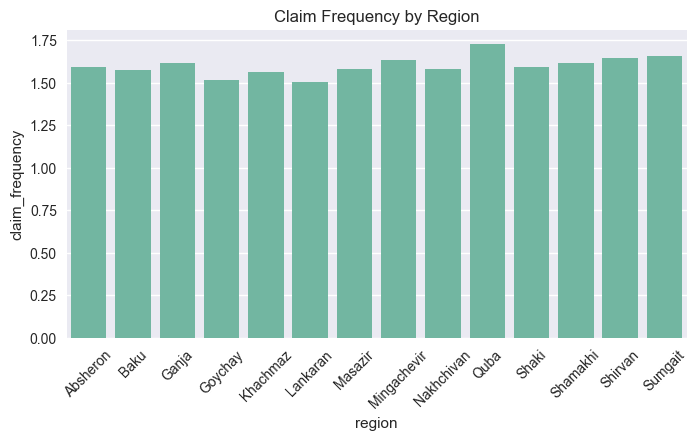

In [26]:

# 9. Calculate claim frequency and severity by region
region_stats = merged.groupby('region').agg({
    'claim_count':'sum',
    'policy_id':'nunique',
    'approved_amount':'mean'
}).reset_index()

region_stats['claim_frequency'] = region_stats['claim_count'] / region_stats['policy_id']
region_stats.rename(columns={'approved_amount':'avg_claim_severity'}, inplace=True)

display(region_stats)

plt.figure(figsize=(8,4))
sns.barplot(data=region_stats, x='region', y='claim_frequency')
plt.title("Claim Frequency by Region")
plt.xticks(rotation=45)
plt.show()


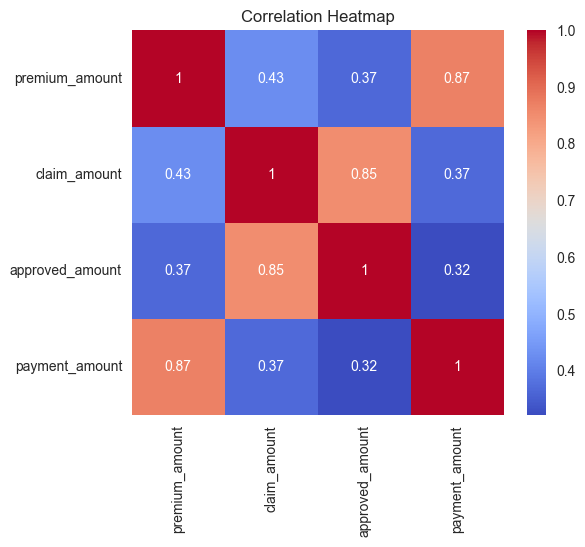

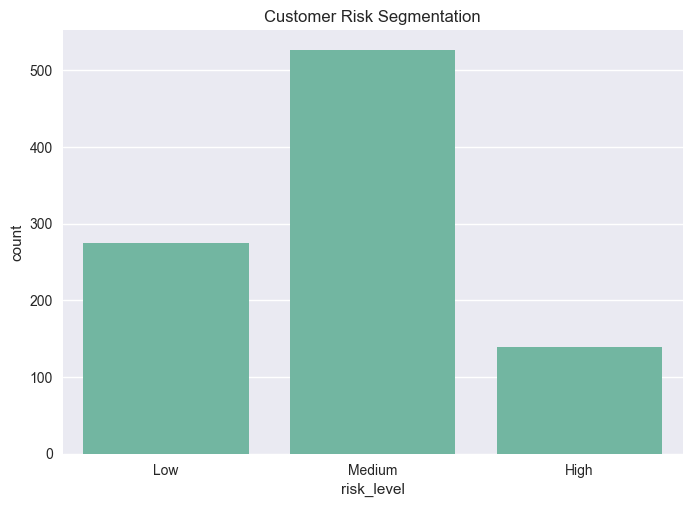

In [27]:

# 10. Generate correlation heatmap and create risk segmentation
numeric_cols = ['premium_amount','claim_amount','approved_amount','payment_amount']
corr = merged[numeric_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Customer segmentation based on loss ratio
risk['risk_level'] = pd.cut(risk['loss_ratio'],
                            bins=[0,0.3,0.8,1.5],
                            labels=['Low','Medium','High'])
sns.countplot(data=risk, x='risk_level', order=['Low','Medium','High'])
plt.title("Customer Risk Segmentation")
plt.show()
